# Прогнозирование оттока клиентов Банка

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Борьба-с-дисбалансом-другим-способом" data-toc-modified-id="Борьба-с-дисбалансом-другим-способом-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Борьба с дисбалансом другим способом</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно построить модель со значением *F1*-меры не менее 0.59. 

Дополнительно нужно измерить *AUC-ROC*, сравнивая её значение с *F1*-мерой.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
pd.options.mode.chained_assignment = None

In [2]:
try: 
    data = pd.read_csv('/datasets/Churn.csv')
except: 
    data = pd.read_csv('datasets/Churn.csv')

In [3]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


**Признаки**

* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**

* `Exited` — факт ухода клиента

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Есть данные типа `object`, которые нужно будет преобразовать, а так же есть пропуски в `['Tenure']`

Обработаем пропуски.

In [5]:
data[data.Tenure.isna()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [6]:
data.Tenure.value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [8]:
# процент пропусков в Tenure
data.Tenure.isna().mean()*100

9.09

Пропущенных значений менее 10%, нет очевидного способа, чем можно их заменить, поэтому удалим их. 

In [7]:
data.dropna(inplace=True)

Удалим столбцы с нумерацией срок, Id и фамилиями клиентов, они не нужны для обучения модели.

In [8]:
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [9]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9994,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


Данные подготовлены для дальнейшей работы, удалены пропуски (менее 10%) и лишние столбцы.

## Исследование задачи

Посмотрим распределение величин баланса, зарплаты, числа продкутов и кредитного рейтинга, чтобы исключить выбросы. 

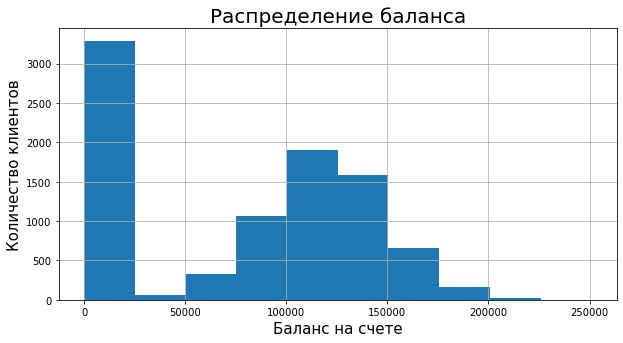

In [10]:
plt.figure(figsize=(10, 5))
data['Balance'].hist()
plt.xlabel('Баланс на счете', fontsize=15)
plt.ylabel('Количество клиентов', fontsize=15)
plt.title('Распределение баланса', fontsize=20);

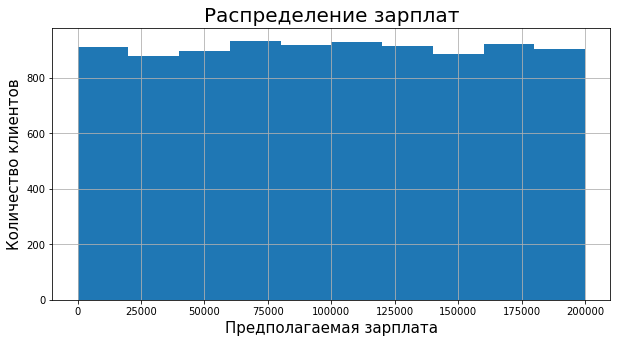

In [11]:
plt.figure(figsize=(10, 5))
data['EstimatedSalary'].hist()
plt.xlabel('Предполагаемая зарплата', fontsize=15)
plt.ylabel('Количество клиентов', fontsize=15)
plt.title('Распределение зарплат', fontsize=20);

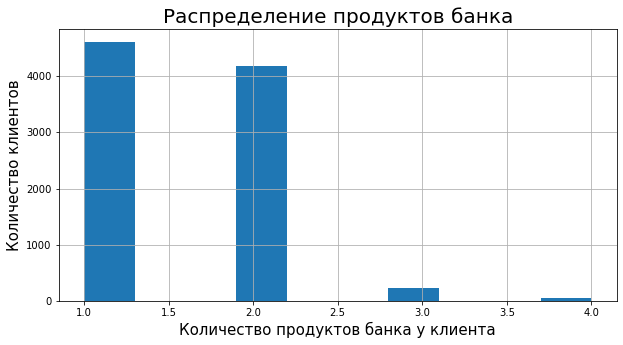

In [12]:
plt.figure(figsize=(10, 5))
data['NumOfProducts'].hist()
plt.xlabel('Количество продуктов банка у клиента', fontsize=15)
plt.ylabel('Количество клиентов', fontsize=15)
plt.title('Распределение продуктов банка', fontsize=20);

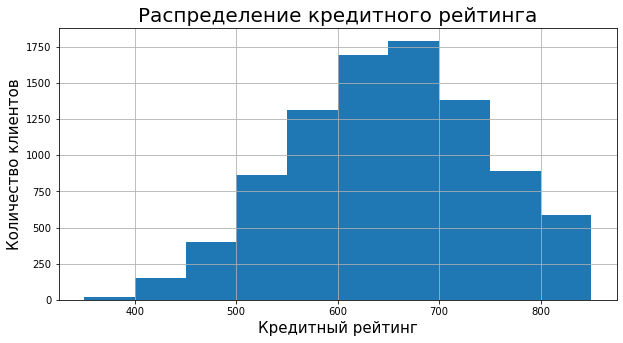

In [13]:
plt.figure(figsize=(10, 5))
data['CreditScore'].hist()
plt.xlabel('Кредитный рейтинг', fontsize=15)
plt.ylabel('Количество клиентов', fontsize=15)
plt.title('Распределение кредитного рейтинга', fontsize=20);

Среди данных нет резко выбивающихся значений.

In [14]:
data.Exited.mean()

0.2039379606203938

В целевом признаке значения распределены неравномерно, 20% значений равны 1, 80% - 0. 

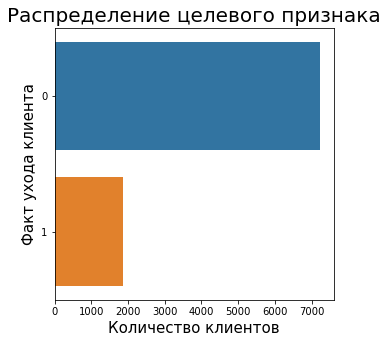

In [15]:
plt.figure(figsize=(5, 5))
sns.countplot(y="Exited", data=data)
plt.xlabel('Количество клиентов', fontsize=15)
plt.ylabel('Факт ухода клиента', fontsize=15)
plt.title('Распределение целевого признака', fontsize=20);

Преобразуем  категориальные признаки в численные, используя технику прямого кодирования, или отображения (англ. One-Hot Encoding, OHE).

In [17]:
# Кодируем столбцы с object данными: [Geography] и [Gender]
data_ohe = pd.get_dummies(data, drop_first=True)

In [18]:
data_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2.0,0.00,2,0,0,167773.55,0,0,0,0
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0


Выделяем признаки и целевой признак, делим данные на 3 выборки: обучающую, валидационную и тестовую. 

In [19]:
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

In [20]:
features_train, features_rest, target_train, target_rest = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, test_size=0.5, random_state=12345)
print('Размеры обучающей выборки:', features_train.shape, target_train.shape)
print('Размеры валидационной выборки:', features_valid.shape, target_valid.shape)
print('Размеры тестовой выборки:', features_test.shape, target_test.shape)

Размеры обучающей выборки: (5454, 11) (5454,)
Размеры валидационной выборки: (1818, 11) (1818,)
Размеры тестовой выборки: (1819, 11) (1819,)


Ищем лучшую модель без учета дисбаланса.

Тестируем **дерево решений**.

In [21]:
best_model = None
best_result = 0
max_depth = 0
for depth in range (1, 20):
    model =  DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Максимальная глубина:', depth, '_f1 метрика', result, '_AUC ROC:', auc_roc, '_f1 обучающей модели:', result_train)
    if result > best_result:
        best_model = model 
        best_result = result 
        max_depth = depth
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)

Максимальная глубина: 1 _f1 метрика 0.0 _AUC ROC: 0.7027189709474522 _f1 обучающей модели: 0.0
Максимальная глубина: 2 _f1 метрика 0.5304878048780488 _AUC ROC: 0.7550846100464421 _f1 обучающей модели: 0.505664263645726
Максимальная глубина: 3 _f1 метрика 0.3726708074534161 _AUC ROC: 0.7994383873562604 _f1 обучающей модели: 0.42105263157894735
Максимальная глубина: 4 _f1 метрика 0.5414551607445008 _AUC ROC: 0.8213322607900129 _f1 обучающей модели: 0.5284738041002278
Максимальная глубина: 5 _f1 метрика 0.5140712945590994 _AUC ROC: 0.8471027524725867 _f1 обучающей модели: 0.5108493490390577
Максимальная глубина: 6 _f1 метрика 0.5606837606837607 _AUC ROC: 0.8495399046859958 _f1 обучающей модели: 0.5873104997192587
Максимальная глубина: 7 _f1 метрика 0.5764331210191083 _AUC ROC: 0.8346049843812412 _f1 обучающей модели: 0.6487325400931194
Максимальная глубина: 8 _f1 метрика 0.5422077922077922 _AUC ROC: 0.807290103947119 _f1 обучающей модели: 0.6780748663101605
Максимальная глубина: 9 _f1 мет

Метрика f1 не достаточна для требуемого значения 0.59.

**Логистическая регрессия**. 

In [22]:
model = LogisticRegression(random_state=12345, solver='liblinear') 
model.fit(features_train, target_train) 
print('F1 метрика для логистической регрессии:', f1_score(target_valid, model.predict(features_valid)))

F1 метрика для логистической регрессии: 0.07246376811594203


Недостаточное значение метрики.

**Случайный лес**.

In [23]:
best_model = None
best_result = 0
max_depth = 0
for depth in range(1, 20):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Max_depth:', depth, '__f1 метрика', result, '__AUC ROC:', auc_roc, '__f1 на обучающей выборке', result_train)
    if result > best_result:
        best_model = model 
        best_result = result 
        max_depth = depth
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)


Max_depth: 1 __f1 метрика 0.0 __AUC ROC: 0.807323237436425 __f1 на обучающей выборке 0.0
Max_depth: 2 __f1 метрика 0.1918465227817746 __AUC ROC: 0.8116361132944444 __f1 на обучающей выборке 0.14320987654320988
Max_depth: 3 __f1 метрика 0.2377622377622378 __AUC ROC: 0.8331627572217202 __f1 на обучающей выборке 0.19024780175859313
Max_depth: 4 __f1 метрика 0.4219066937119675 __AUC ROC: 0.8438538297711765 __f1 на обучающей выборке 0.3860627177700348
Max_depth: 5 __f1 метрика 0.5156537753222836 __AUC ROC: 0.8554036119184842 __f1 на обучающей выборке 0.5186567164179104
Max_depth: 6 __f1 метрика 0.5490196078431373 __AUC ROC: 0.8601343378916424 __f1 на обучающей выборке 0.5819672131147542
Max_depth: 7 __f1 метрика 0.5650684931506849 __AUC ROC: 0.8612562746545372 __f1 на обучающей выборке 0.6005830903790088
Max_depth: 8 __f1 метрика 0.5758620689655172 __AUC ROC: 0.8661296587066526 __f1 на обучающей выборке 0.6420873511060692
Max_depth: 9 __f1 метрика 0.5501730103806228 __AUC ROC: 0.86987558374

Для выявленной наилучшей максимальной глубины тестируем разное количество числа деревьев.

In [24]:
best_model = None
best_result = 0
n_estimators = 0
for n_est in range(20, 300, 20):
    model = RandomForestClassifier(n_estimators=n_est, max_depth=16, random_state=12345)
    model.fit(features_train, target_train)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Число деревьев:', n_est, 'f1 метрика', result, '__AUC ROC:', auc_roc,'__f1 на обучающей выборке', result_train)
    if result > best_result:
        best_model_tree = model 
        best_result = result 
        n_estimators=n_est
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Число деревьев", n_estimators, 'Глубина:', max_depth)


Число деревьев: 20 f1 метрика 0.5889967637540453 __AUC ROC: 0.8586506938704885 __f1 на обучающей выборке 0.9689497716894977
Число деревьев: 40 f1 метрика 0.5821138211382113 __AUC ROC: 0.8630003847166259 __f1 на обучающей выборке 0.9874213836477987
Число деревьев: 60 f1 метрика 0.5789473684210527 __AUC ROC: 0.8647730263945057 __f1 на обучающей выборке 0.9883198562443846
Число деревьев: 80 f1 метрика 0.5911330049261084 __AUC ROC: 0.8633381622326082 __f1 на обучающей выборке 0.9901345291479821
Число деревьев: 100 f1 метрика 0.5813953488372093 __AUC ROC: 0.8639327242907132 __f1 на обучающей выборке 0.9896814715118887
Число деревьев: 120 f1 метрика 0.5837479270315092 __AUC ROC: 0.8637670568441824 __f1 на обучающей выборке 0.9892280071813285
Число деревьев: 140 f1 метрика 0.5823627287853578 __AUC ROC: 0.8647987968861882 __f1 на обучающей выборке 0.9896814715118887
Число деревьев: 160 f1 метрика 0.5766666666666667 __AUC ROC: 0.8637284011066585 __f1 на обучающей выборке 0.9901345291479821
Числ

In [26]:
best_model = None
best_result = 0
n_estimators = 0
for n_est in range(75, 85, 1):
    model = RandomForestClassifier(n_estimators=n_est, max_depth=16, random_state=12345)
    model.fit(features_train, target_train)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Число деревьев:', n_est, '__f1 метрика', result,  '__AUC ROC:', auc_roc,'__f1 на обучающей выборке', result_train)
    
    if result > best_result:
        best_model = model 
        best_result = result 
        n_estimators=n_est
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Число деревьев", n_estimators, 'Глубина:', max_depth)

Число деревьев: 75 __f1 метрика 0.5851239669421487 __AUC ROC: 0.8649764292038574 __f1 на обучающей выборке 0.9905871806364859
Число деревьев: 76 __f1 метрика 0.5864909390444811 __AUC ROC: 0.864169260589371 __f1 на обучающей выборке 0.9905871806364859
Число деревьев: 77 __f1 метрика 0.5911330049261084 __AUC ROC: 0.8640707804961555 __f1 на обучающей выборке 0.9896814715118887
Число деревьев: 78 __f1 метрика 0.5864909390444811 __AUC ROC: 0.8638922278037835 __f1 на обучающей выборке 0.9901345291479821
Число деревьев: 79 __f1 метрика 0.5921052631578947 __AUC ROC: 0.8635130334261684 __f1 на обучающей выборке 0.9896814715118887
Число деревьев: 80 __f1 метрика 0.5911330049261084 __AUC ROC: 0.8633381622326082 __f1 на обучающей выборке 0.9901345291479821
Число деревьев: 81 __f1 метрика 0.5907590759075908 __AUC ROC: 0.8631025463086531 __f1 на обучающей выборке 0.9905871806364859
Число деревьев: 82 __f1 метрика 0.5874587458745875 __AUC ROC: 0.8632516470105309 __f1 на обучающей выборке 0.9905871806

In [27]:
model = best_model
model.fit(features_train, target_train)
print(confusion_matrix(target_valid, model.predict(features_valid)))

[[1390   51]
 [ 197  180]]


Наилучшее значение  f1 = 0.59 получилось в модели случайный лес с глубиной 16 и 79 деревьями. Теперь проведем аналогичные тестирования с учетом дисбаланса.

## Борьба с дисбалансом

Для борьбы с дисбалансом будем использовать аргумент class_weight.

**Дерево решений**

In [28]:
best_model = None
best_result = 0
max_depth = 0
for depth in range (1, 25):
    model =  DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Max_depth:', depth, '___f1 метрика', result,  '__AUC ROC:', auc_roc,'__f1 обучающей модели:', result_train)
    if result > best_result:
        best_model = model 
        best_result = result 
        max_depth = depth
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)

Max_depth: 1 ___f1 метрика 0.5065856129685917 __AUC ROC: 0.7066517320531535 __f1 обучающей модели: 0.48602002071108047
Max_depth: 2 ___f1 метрика 0.5297619047619048 __AUC ROC: 0.7580721463322148 __f1 обучающей модели: 0.5129064699966477
Max_depth: 3 ___f1 метрика 0.548936170212766 __AUC ROC: 0.7949267105624042 __f1 обучающей модели: 0.5387962291515591
Max_depth: 4 ___f1 метрика 0.5461187214611872 __AUC ROC: 0.8178983427733099 __f1 обучающей модели: 0.5344827586206896
Max_depth: 5 ___f1 метрика 0.5735449735449736 __AUC ROC: 0.8396523192522141 __f1 обучающей модели: 0.5921100253347811
Max_depth: 6 ___f1 метрика 0.5630885122410546 __AUC ROC: 0.8320960429410021 __f1 обучающей модели: 0.5920000000000001
Max_depth: 7 ___f1 метрика 0.5413533834586466 __AUC ROC: 0.8106043732524385 __f1 обучающей модели: 0.6076585059635907
Max_depth: 8 ___f1 метрика 0.5581896551724138 __AUC ROC: 0.7869498230119446 __f1 обучающей модели: 0.6572537945640664
Max_depth: 9 ___f1 метрика 0.5059978189749182 __AUC ROC:

У дерева решений метрика все еще не достигла требуемого значения 0.59.

**Логистическая регрессия**.

In [29]:
model = LogisticRegression(random_state=12345, solver='liblinear',  class_weight='balanced') 
model.fit(features_train, target_train) 
print(f1_score(target_valid, model.predict(features_valid)))

0.4888888888888889


У логистической регрессии метрика значительно улучшилась по сравнению с предыдущим испытанием без учета дисбаланса, но все равно не достигла требуемого значния. 

**Случайный лес**.

In [30]:
best_model = None
best_result = 0
max_depth = 0
for depth in range(1, 30):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Max_depth:', depth, '___f1 метрика',result, '__AUC ROC:', auc_roc, '__f1 на обучающей выборке', result_train)
    if result > best_result:
        best_model = model 
        best_result = result 
        max_depth = depth
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)

Max_depth: 1 ___f1 метрика 0.5513928914505284 __AUC ROC: 0.8222922116051887 __f1 на обучающей выборке 0.535443455324761
Max_depth: 2 ___f1 метрика 0.5731225296442689 __AUC ROC: 0.83473567758906 __f1 на обучающей выборке 0.5542248835662009
Max_depth: 3 ___f1 метрика 0.5821782178217823 __AUC ROC: 0.8470585744868451 __f1 на обучающей выборке 0.5679839249832551
Max_depth: 4 ___f1 метрика 0.5824847250509165 __AUC ROC: 0.8525412465923127 __f1 на обучающей выборке 0.5871238628411477
Max_depth: 5 ___f1 метрика 0.5976008724100327 __AUC ROC: 0.8587859889518221 __f1 на обучающей выборке 0.6143547787281517
Max_depth: 6 ___f1 метрика 0.6133625410733844 __AUC ROC: 0.8639842652740785 __f1 на обучающей выборке 0.6311475409836065
Max_depth: 7 ___f1 метрика 0.6087912087912088 __AUC ROC: 0.862580693852081 __f1 на обучающей выборке 0.6659056316590564
Max_depth: 8 ___f1 метрика 0.6305882352941177 __AUC ROC: 0.8652203285001391 __f1 на обучающей выборке 0.7099327265532251
Max_depth: 9 ___f1 метрика 0.6321112

Выявили лучшее значение глубины, теперь меняем число деревьев. Показания метрики уже превышают требуемое значение 0,59.

In [31]:
best_model = None
best_result = 0
n_estimators = 0
for n_est in range(10, 200, 10):
    model = RandomForestClassifier(n_estimators=n_est, max_depth=9, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Число деревьев:', n_est, 'f1 метрика', result, '__AUC ROC:', auc_roc,'__f1 на обучающей выборке', result_train)
    if result > best_result:
        best_model = model 
        best_result = result 
        n_estimators=n_est
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Число деревьев", n_estimators, 'Глубина:', max_depth)

Число деревьев: 10 f1 метрика 0.6497584541062802 __AUC ROC: 0.8689340404265387 __f1 на обучающей выборке 0.7413723101908243
Число деревьев: 20 f1 метрика 0.6321112515802781 __AUC ROC: 0.8715994455662789 __f1 на обучающей выборке 0.7618651124063279
Число деревьев: 30 f1 метрика 0.6382978723404255 __AUC ROC: 0.8720182160561207 __f1 на обучающей выборке 0.7693588676103248
Число деревьев: 40 f1 метрика 0.6423173803526449 __AUC ROC: 0.8700191622013154 __f1 на обучающей выборке 0.7745952677459526
Число деревьев: 50 f1 метрика 0.6349999999999999 __AUC ROC: 0.8699179209839909 __f1 на обучающей выборке 0.7810158201498751
Число деревьев: 60 f1 метрика 0.6348808030112923 __AUC ROC: 0.869233162204997 __f1 на обучающей выборке 0.7791231732776617
Число деревьев: 70 f1 метрика 0.6294416243654822 __AUC ROC: 0.8697264830457776 __f1 на обучающей выборке 0.779491454772822
Число деревьев: 80 f1 метрика 0.6306532663316582 __AUC ROC: 0.8690269982715363 __f1 на обучающей выборке 0.7776387150604922
Число дере

In [32]:
best_model = None
best_result = 0
n_estimators = 0
for n_est in range(5, 20):
    model = RandomForestClassifier(n_estimators=n_est, max_depth=9, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Число деревьев:', n_est, '__f1 метрика',result, '__AUC ROC:', auc_roc, '___f1 на обучающей выборке', result_train, )
    
    if result > best_result:
        best_model = model 
        best_result = result 
        n_estimators=n_est
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Число деревьев", n_estimators, 'Глубина:', max_depth)

Число деревьев: 5 __f1 метрика 0.6192170818505337 __AUC ROC: 0.8532158812495743 ___f1 на обучающей выборке 0.7114779874213837
Число деревьев: 6 __f1 метрика 0.6254458977407847 __AUC ROC: 0.8564325908363812 ___f1 на обучающей выборке 0.7162270183852918
Число деревьев: 7 __f1 метрика 0.6275449101796408 __AUC ROC: 0.860793326178954 ___f1 на обучающей выборке 0.7218225419664269
Число деревьев: 8 __f1 метрика 0.636144578313253 __AUC ROC: 0.8633390826073111 ___f1 на обучающей выборке 0.7347436940602114
Число деревьев: 9 __f1 метрика 0.6340269277845777 __AUC ROC: 0.866828223106191 ___f1 на обучающей выборке 0.7427639624949042
Число деревьев: 10 __f1 метрика 0.6497584541062802 __AUC ROC: 0.8689340404265387 ___f1 на обучающей выборке 0.7413723101908243
Число деревьев: 11 __f1 метрика 0.639225181598063 __AUC ROC: 0.8700467734424039 ___f1 на обучающей выборке 0.7426470588235293
Число деревьев: 12 __f1 метрика 0.6410891089108911 __AUC ROC: 0.8709745111429765 ___f1 на обучающей выборке 0.7468982630

In [33]:
model = best_model
model.fit(features_train, target_train)
print(confusion_matrix(target_valid, model.predict(features_valid)))

[[1259  182]
 [ 108  269]]


С учетом дисбаланса значение метрики f1 значительно увеличилось и стало выше требуемого значения 0,59:
* F1 наилучшей модели на валидационной выборке: 0.6497584541062802
* Число деревьев 10 Глубина: 9

При этом AUC-ROC метрика равна 0.8689340404265387, это лучше, чем у случайной модели.

### Борьба с дисбалансом другим способом

Попробуем убрать дисбаланс техникой upsampling. 

Для этого создадим функцию, которая увеличит количество 1 в целевом признаке, чтобы избавиться от дисбаланса.

In [34]:
def upsample(features, target, repeat):
    """Функция копирует несколько раз (repeat) положительные объекты,
    создает новую обучающую выборку и перемешивает данные"""
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


In [35]:
#Теперь 1 и 0 поровну
target_upsampled.mean()

0.509963768115942

**Дерево решений**

In [36]:
best_model = None
best_result = 0
max_depth = 0
for depth in range (1, 25):
    model =  DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Max_depth:', depth, '___f1 метрика', result,  '__AUC ROC:', auc_roc,'__f1 обучающей модели:', result_train)
    if result > best_result:
        best_model = model 
        best_result = result 
        max_depth = depth
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)

Max_depth: 1 ___f1 метрика 0.5065856129685917 __AUC ROC: 0.7066517320531535 __f1 обучающей модели: 0.48602002071108047
Max_depth: 2 ___f1 метрика 0.5297619047619048 __AUC ROC: 0.7580721463322148 __f1 обучающей модели: 0.5129064699966477
Max_depth: 3 ___f1 метрика 0.548936170212766 __AUC ROC: 0.7949267105624042 __f1 обучающей модели: 0.5387962291515591
Max_depth: 4 ___f1 метрика 0.5461187214611872 __AUC ROC: 0.8178983427733099 __f1 обучающей модели: 0.5344827586206896
Max_depth: 5 ___f1 метрика 0.5735449735449736 __AUC ROC: 0.8396523192522141 __f1 обучающей модели: 0.5921100253347811
Max_depth: 6 ___f1 метрика 0.5630885122410546 __AUC ROC: 0.8321227338073877 __f1 обучающей модели: 0.5920000000000001
Max_depth: 7 ___f1 метрика 0.5413533834586466 __AUC ROC: 0.8105454692714498 __f1 обучающей модели: 0.6076585059635907
Max_depth: 8 ___f1 метрика 0.5581395348837209 __AUC ROC: 0.7901149916153866 __f1 обучающей модели: 0.6506189821182944
Max_depth: 9 ___f1 метрика 0.5159165751920965 __AUC ROC:

Результаты такие же, как при использовании аргумента class_weight='balanced'

**Логистическая регрессия**

In [37]:
model = LogisticRegression(random_state=12345, solver='liblinear') 
model.fit(features_upsampled, target_upsampled) 
print(f1_score(target_valid, model.predict(features_valid)))

0.47457627118644063


Здесь результат хуже, чем при использовании аргумента class_weight='balanced'. Попробуем изменение порога.

In [38]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    f1 = f1_score(target_valid, predicted_valid)
    

    print("Порог = {:.2f} | f1 метрика = {:.3f}".format(
        threshold, f1))

Порог = 0.00 | f1 метрика = 0.344
Порог = 0.02 | f1 метрика = 0.344
Порог = 0.04 | f1 метрика = 0.343
Порог = 0.06 | f1 метрика = 0.347
Порог = 0.08 | f1 метрика = 0.353
Порог = 0.10 | f1 метрика = 0.363
Порог = 0.12 | f1 метрика = 0.373
Порог = 0.14 | f1 метрика = 0.393
Порог = 0.16 | f1 метрика = 0.404
Порог = 0.18 | f1 метрика = 0.422
Порог = 0.20 | f1 метрика = 0.436
Порог = 0.22 | f1 метрика = 0.438
Порог = 0.24 | f1 метрика = 0.436
Порог = 0.26 | f1 метрика = 0.421
Порог = 0.28 | f1 метрика = 0.403
Порог = 0.30 | f1 метрика = 0.384
Порог = 0.32 | f1 метрика = 0.354
Порог = 0.34 | f1 метрика = 0.312
Порог = 0.36 | f1 метрика = 0.272
Порог = 0.38 | f1 метрика = 0.240
Порог = 0.40 | f1 метрика = 0.217
Порог = 0.42 | f1 метрика = 0.191
Порог = 0.44 | f1 метрика = 0.151
Порог = 0.46 | f1 метрика = 0.141
Порог = 0.48 | f1 метрика = 0.100
Порог = 0.50 | f1 метрика = 0.072
Порог = 0.52 | f1 метрика = 0.059
Порог = 0.54 | f1 метрика = 0.050
Порог = 0.56 | f1 метрика = 0.015
Порог = 0.58 |

Наилучший результат: Порог = 0.22 | f1 метрика = 0.438 - меньше требуемого.

Теперь попробуем со сбалансированными данными.

In [39]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    f1 = f1_score(target_valid, predicted_valid)
    

    print("Порог = {:.2f} | f1 метрика = {:.3f}".format(
        threshold, f1))

Порог = 0.00 | f1 метрика = 0.344
Порог = 0.02 | f1 метрика = 0.344
Порог = 0.04 | f1 метрика = 0.344
Порог = 0.06 | f1 метрика = 0.344
Порог = 0.08 | f1 метрика = 0.344
Порог = 0.10 | f1 метрика = 0.344
Порог = 0.12 | f1 метрика = 0.344
Порог = 0.14 | f1 метрика = 0.343
Порог = 0.16 | f1 метрика = 0.344
Порог = 0.18 | f1 метрика = 0.346
Порог = 0.20 | f1 метрика = 0.348
Порог = 0.22 | f1 метрика = 0.350
Порог = 0.24 | f1 метрика = 0.353
Порог = 0.26 | f1 метрика = 0.358
Порог = 0.28 | f1 метрика = 0.363
Порог = 0.30 | f1 метрика = 0.368
Порог = 0.32 | f1 метрика = 0.375
Порог = 0.34 | f1 метрика = 0.383
Порог = 0.36 | f1 метрика = 0.390
Порог = 0.38 | f1 метрика = 0.402
Порог = 0.40 | f1 метрика = 0.418
Порог = 0.42 | f1 метрика = 0.429
Порог = 0.44 | f1 метрика = 0.440
Порог = 0.46 | f1 метрика = 0.455
Порог = 0.48 | f1 метрика = 0.463
Порог = 0.50 | f1 метрика = 0.475
Порог = 0.52 | f1 метрика = 0.480
Порог = 0.54 | f1 метрика = 0.479
Порог = 0.56 | f1 метрика = 0.480
Порог = 0.58 |

Наилучший результат : Порог = 0.52 | f1 метрика = 0.480 - меньше требуемого. 
Здесь мы можем наблюдать, что наилучший результат метрики достигается  при пороге близком по значению к target.mean().

**Случайный лес**

In [40]:
best_model = None
best_result = 0
max_depth = 0
for depth in range(1, 30):
    model = RandomForestClassifier(n_estimators=20, max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Max_depth:', depth, '___f1 метрика',result, '__AUC ROC:', auc_roc, '__f1 на обучающей выборке', result_train)
    if result > best_result:
        best_model = model 
        best_result = result 
        max_depth = depth
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Максимальная глубина:", max_depth)

Max_depth: 1 ___f1 метрика 0.5399811853245532 __AUC ROC: 0.8052938112164224 __f1 на обучающей выборке 0.5255709231264072
Max_depth: 2 ___f1 метрика 0.5513307984790875 __AUC ROC: 0.8222029352590027 __f1 на обучающей выборке 0.529639175257732
Max_depth: 3 ___f1 метрика 0.5605214152700186 __AUC ROC: 0.8414626962929147 __f1 на обучающей выборке 0.539602398232881
Max_depth: 4 ___f1 метрика 0.5969543147208121 __AUC ROC: 0.8505532372339428 __f1 на обучающей выборке 0.5873400207540643
Max_depth: 5 ___f1 метрика 0.6059957173447538 __AUC ROC: 0.8600662301636242 __f1 на обучающей выборке 0.6126709863210943
Max_depth: 6 ___f1 метрика 0.6012793176972281 __AUC ROC: 0.8625760919785663 __f1 на обучающей выборке 0.6449038810301051
Max_depth: 7 ___f1 метрика 0.6162162162162163 __AUC ROC: 0.861591291046411 __f1 на обучающей выборке 0.6613080014614542
Max_depth: 8 ___f1 метрика 0.6165577342047931 __AUC ROC: 0.8660946844679406 __f1 на обучающей выборке 0.707635009310987
Max_depth: 9 ___f1 метрика 0.6066666

In [41]:
best_model = None
best_result = 0
n_estimators = 0
for n_est in range(10, 200, 10):
    model = RandomForestClassifier(n_estimators=n_est, max_depth=8, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Число деревьев:', n_est, 'f1 метрика', result, '__AUC ROC:', auc_roc,'__f1 на обучающей выборке', result_train)
    if result > best_result:
        best_model = model 
        best_result = result 
        n_estimators=n_est
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Число деревьев", n_estimators, 'Глубина:', max_depth)

Число деревьев: 10 f1 метрика 0.6000000000000001 __AUC ROC: 0.8540598648521786 __f1 на обучающей выборке 0.7113095238095238
Число деревьев: 20 f1 метрика 0.6165577342047931 __AUC ROC: 0.8660946844679406 __f1 на обучающей выборке 0.707635009310987
Число деревьев: 30 f1 метрика 0.6236323851203501 __AUC ROC: 0.8675396727515705 __f1 на обучающей выборке 0.7118133935289692
Число деревьев: 40 f1 метрика 0.6266375545851528 __AUC ROC: 0.8684250732158076 __f1 на обучающей выборке 0.7135867519759127
Число деревьев: 50 f1 метрика 0.6157205240174672 __AUC ROC: 0.86809189757334 __f1 на обучающей выборке 0.7100635989524878
Число деревьев: 60 f1 метрика 0.6236323851203501 __AUC ROC: 0.8681747312966055 __f1 на обучающей выборке 0.7136960600375234
Число деревьев: 70 f1 метрика 0.6278814489571899 __AUC ROC: 0.8683238319984833 __f1 на обучающей выборке 0.7156789197299324
Число деревьев: 80 f1 метрика 0.6256860592755215 __AUC ROC: 0.8697191200481541 __f1 на обучающей выборке 0.7154654654654654
Число дерев

In [42]:
best_model = None
best_result = 0
n_estimators = 0
for n_est in range(85, 95):
    model = RandomForestClassifier(n_estimators=n_est, max_depth=8, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    result = f1_score(target_valid, model.predict(features_valid))
    result_train = f1_score(target_train, model.predict(features_train))
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('Число деревьев:', n_est, '__f1 метрика',result, '__AUC ROC:', auc_roc, '___f1 на обучающей выборке', result_train, )
    
    if result > best_result:
        best_model = model 
        best_result = result 
        n_estimators=n_est
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)
print("Число деревьев", n_estimators, 'Глубина:', max_depth)

Число деревьев: 85 __f1 метрика 0.6274509803921567 __AUC ROC: 0.8695240006111288 ___f1 на обучающей выборке 0.7167414050822122
Число деревьев: 86 __f1 метрика 0.6244541484716158 __AUC ROC: 0.8696749420624125 ___f1 на обучающей выборке 0.7159387831280328
Число деревьев: 87 __f1 метрика 0.6271929824561403 __AUC ROC: 0.8699105579863675 ___f1 на обучающей выборке 0.7164736645498693
Число деревьев: 88 __f1 метрика 0.6271929824561403 __AUC ROC: 0.8700338881965626 ___f1 на обучающей выборке 0.7167976056864946
Число деревьев: 89 __f1 метрика 0.6300768386388583 __AUC ROC: 0.870098314425769 ___f1 на обучающей выборке 0.7161048689138577
Число деревьев: 90 __f1 метрика 0.6300768386388583 __AUC ROC: 0.8698590170030022 ___f1 на обучающей выборке 0.7166979362101313
Число деревьев: 91 __f1 метрика 0.6299559471365638 __AUC ROC: 0.8699123987357732 ___f1 на обучающей выборке 0.7148203592814372
Число деревьев: 92 __f1 метрика 0.6300768386388583 __AUC ROC: 0.8699565767215149 ___f1 на обучающей выборке 0.71

Значение f1 получилось 0.6306504961411246, это значение превышает требуемый показатель, но с при использовании аргумента class_weight='balanced'  результат был выше. 
Поэтому оставляем лучшей предыдущую модель.
* F1 наилучшей модели на валидационной выборке: 0.6497584541062802
* Число деревьев 10 Глубина: 9

## Тестирование модели

Тестируем лучшую модель на тестовой выборке.

In [43]:
model =  RandomForestClassifier(n_estimators=10, max_depth=9, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
print(f1_score(target_test, model.predict(features_test)))

0.5936675461741425


Значение метрики f1 на тестовой выборке превысило требуемое значение 0.59.

## Вывод

Нам было нужно  спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Для этого мы построили модели классификации и выбрали модель с наилучшими показателями метрики f1. 
Этой моделью оказался случайный лес с 10 деревьями и глубиной 9 и аргументом `class_weight='balanced'`. 

Испытание на тестовой выборке показало значение метрики 0.5936675461741425, что выше требуемого 0.59.